###Linear Regression with Multiple Features/ Variables

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files
uploaded = files.upload()

Saving deeplearning.mplstyle to deeplearning.mplstyle


In [33]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
from lab_utils_multi import  load_house_data, run_gradient_descent
from lab_utils_multi import  norm_plot, plt_equal_scale, plot_cost_i_w, zscore_normalize_features, run_gradient_descent_feng
from lab_utils_common import dlc
plt.style.use('./deeplearning.mplstyle')
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays

The training dataset contains three examples with four features (size, bedrooms, floors and, age) shown in the table below.  Note that, unlike the earlier labs, size is in sqft rather than 1000 sqft.

| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|-------------- |  
| 2104            | 5                   | 1                | 45           | 460           |  
| 1416            | 3                   | 2                | 40           | 232           |  
| 852             | 2                   | 1                | 35           | 178           |  

Building a linear regression model using these values and then predict the price for other houses. For example, a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old.  


In [72]:
x_train = np.array([[2104, 5, 1, 45], [1416, 3, 2, 40], [852, 2, 1, 35]])
y_train = np.array([460, 232, 178])

####Matrix X containing the above examples
Similar to the table above, examples are stored in a NumPy matrix `X_train`. Each row of the matrix represents one example. When you have $m$ training examples ( $m$ is three in our example), and there are $n$ features (four in our example), $\mathbf{X}$ is a matrix with dimensions ($m$, $n$) (m rows, n columns).


$$\mathbf{X} =
\begin{pmatrix}
 x^{(0)}_0 & x^{(0)}_1 & \cdots & x^{(0)}_{n-1} \\
 x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_{n-1} \\
 \cdots \\
 x^{(m-1)}_0 & x^{(m-1)}_1 & \cdots & x^{(m-1)}_{n-1}
\end{pmatrix}
$$
notation:
- $\mathbf{x}^{(i)}$ is vector containing example i. $\mathbf{x}^{(i)}$ $ = (x^{(i)}_0, x^{(i)}_1, \cdots,x^{(i)}_{n-1})$
- $x^{(i)}_j$ is element j in example i. The superscript in parenthesis indicates the example number while the subscript represents an element.  

In [9]:
print(f'X Shape: {x_train.shape}, X Type:{type(x_train)})')
print(x_train)
print(f'y Shape: {y_train.shape}, y Type:{type(y_train)})')

X Shape: (3, 4), X Type:<class 'numpy.ndarray'>)
[[2104    5    1   45]
 [1416    3    2   40]
 [ 852    2    1   35]]
y Shape: (3,), y Type:<class 'numpy.ndarray'>)


####Parameter vector w, b

* $\mathbf{w}$ is a vector with $n$ elements.
  - Each element contains the parameter associated with one feature.
  - in our dataset, n is 4.
  - notionally, we draw this as a column vector

$$\mathbf{w} = \begin{pmatrix}
w_0 \\
w_1 \\
\cdots\\
w_{n-1}
\end{pmatrix}
$$
* $b$ is a scalar parameter.  

In [20]:
b_init = 785.1811367994083
w_init = np.array([ 0.39133535, 18.75376741, -53.36032453, -26.42131618])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")

w_init shape: (4,), b_init type: <class 'float'>


####Model Prediction With Multiple Variables
The model's prediction with multiple variables is given by the linear model:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$
where $\cdot$ is a vector `dot product`

To demonstrate the dot product, we will implement prediction using (1) and (2).

So, vectorization provides a large speed up. This is because NumPy makes better use of available data parallelism in the underlying hardware. GPU's and modern CPU's implement Single Instruction, Multiple Data (SIMD) pipelines allowing multiple operations to be issued in parallel. This is critical in Machine Learning where the data sets are often very large.

In [21]:
def predict(x, w, b):
  p = np.dot(x,w)+b
  return p

In [12]:
x_vec = x_train[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")

f_wb = predict(x_vec,w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb}")

x_vec shape (4,), x_vec value: [2104    5    1   45]
f_wb shape (), prediction: 459.9999976194083


####Compute Cost With Multiple Variables
The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$

$\mathbf{w}$ and $\mathbf{x}^{(i)}$ are vectors rather than scalars supporting multiple features.

In [22]:
def compute_cost(X, y, w, b):
  m = X.shape[0]
  cost = 0.0
  for i in range(m):
    f_wb_i = np.dot(X[i],w) + b
    cost = cost + (f_wb_i - y[i])**2
  cost = cost / (2*m)
  return cost

In [23]:
cost = compute_cost(x_train, y_train, w_init, b_init)
print(f'Cost at optimal w : {cost}')

Cost at optimal w : 1.5578904428966628e-12


####Gradient Descent With Multiple Variables

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


An implementation for calculating the equations (6) and (7) is below. There are many ways to implement this. In this version, there is an
- outer loop over all m examples.
    - $\frac{\partial J(\mathbf{w},b)}{\partial b}$ for the example can be computed directly and accumulated
    - in a second loop over all n features:
  - $\frac{\partial J(\mathbf{w},b)}{\partial w_j}$ is computed for each $w_j$.

In [24]:
def compute_gradient(X, y, w, b):
  m, n = X.shape
  dj_dw = np.zeros((n,))
  dj_db = 0.

  for i in range(m):
    err = (np.dot(X[i], w) + b) - y[i]
    for j in range(n):
      dj_dw[j] = dj_dw[j] + err * X[i, j]
    dj_db = dj_db + err
  dj_dw = dj_dw/m
  dj_db = dj_db/m
  return dj_db, dj_dw

In [28]:
tmp_dj_db, tmp_dj_dw = compute_gradient(x_train, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

dj_db at initial w,b: -1.6739251501955248e-06
dj_dw at initial w,b: 
 [-2.73e-03 -6.27e-06 -2.22e-06 -6.92e-05]


In [29]:
def gradient_descent(X, y, w, b, alpha, num_iters, cost_function, gradient_function):

  J_history = []
  w = copy.deepcopy(w)
  b = b

  for i in range(num_iters):
    dj_db, dj_dw = gradient_function(X, y, w, b)

    w = w - alpha * dj_dw
    b = b - alpha * dj_db

    if i < 100000:
      J_history.append(cost_function(X, y, w, b))

    if i % math.ceil(num_iters/10) == 0:
      print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")

  return w, b, J_history

In [30]:
import math
initial_w = np.zeros_like(w_init)
initial_b = 0
iterations = 10000
alpha = 5.0e-7

w_final, b_final, J_hist = gradient_descent(x_train, y_train, initial_w, initial_b, alpha, iterations, compute_cost, compute_gradient)

print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")

m,_ = x_train.shape
for i in range(m):
  print(f"prediction: {np.dot(x_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost  2529.46   
Iteration 1000: Cost   686.69   
Iteration 2000: Cost   677.19   
Iteration 3000: Cost   668.48   
Iteration 4000: Cost   660.50   
Iteration 5000: Cost   653.19   
Iteration 6000: Cost   646.49   
Iteration 7000: Cost   640.35   
Iteration 8000: Cost   634.72   
Iteration 9000: Cost   629.56   
b,w found by gradient descent: -0.02,[ 0.22  0.03 -0.11 -0.58] 
prediction: 430.50, target value: 460
prediction: 283.93, target value: 232
prediction: 164.52, target value: 178


b,w found by gradient descent: -0.00,[ 0.2   0.   -0.01 -0.07]   
prediction: 426.19, target value: 460  
prediction: 286.17, target value: 232  
prediction: 171.47, target value: 178  

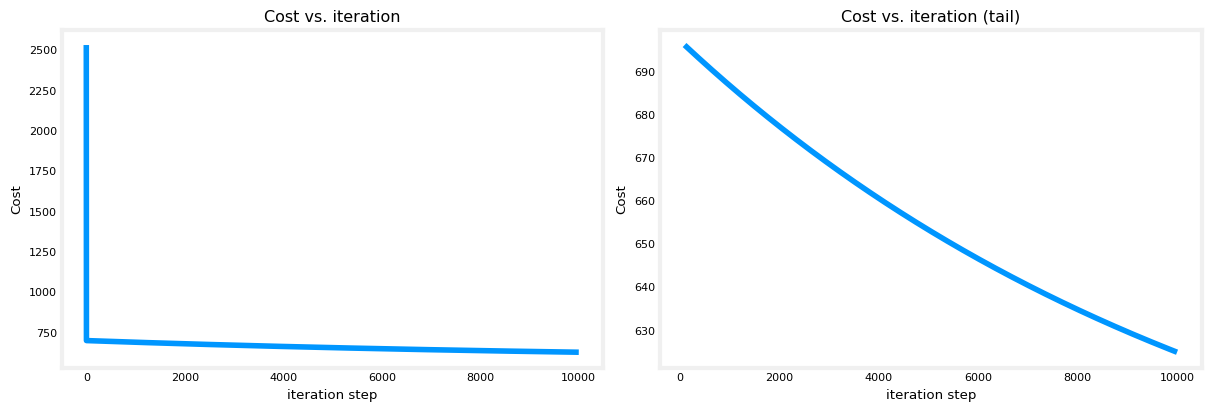

In [31]:
# plot cost versus iteration
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step')
plt.show()

*These results are not inspiring*! Cost is still declining and our predictions are not very accurate.

Let's try Feature Engineering and then see the results


###Scale/normalize the training data

In [65]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_norm = scaler.fit_transform(x_train)
print(f"Peak to Peak range by column in Raw        X:{np.ptp(x_train,axis=0)}")
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

Peak to Peak range by column in Raw        X:[1252    3    1   10]
Peak to Peak range by column in Normalized X:[2.45 2.41 2.12 2.45]


 ### Create and fit the regression model

In [73]:
sgdr = SGDRegressor(max_iter=10000)
sgdr.fit(X_norm, y_train)
print(sgdr)
print(f"number of iterations completed: {sgdr.n_iter_}, number of weight updates: {sgdr.t_}")

SGDRegressor(max_iter=10000)
number of iterations completed: 1241, number of weight updates: 3724.0


### View parameters
Note, the parameters are associated with the *normalized* input data. The fit parameters are very close to those found in the previous lab with this data.

In [68]:
b_norm = sgdr.intercept_
w_norm = sgdr.coef_
print(f"model parameters:                   w: {w_norm}, b:{b_norm}")
print( "model parameters from previous : w:  [0.22  0.03 -0.11 -0.58], b: -0.02")

model parameters:                   w: [ 38.05  41.54 -30.95  36.35], b:[289.51]
model parameters from previous : w:  [0.22  0.03 -0.11 -0.58], b: -0.02


### Make predictions
Predict the targets of the training data. Use both the `predict` routine and compute using $w$ and $b$.

In [74]:
# make a prediction using sgdr.predict()
y_pred_sgd = sgdr.predict(X_norm)
# make a prediction using w,b.
y_pred = np.dot(X_norm, w_norm) + b_norm
print(f"prediction using np.dot() and sgdr.predict match: {(y_pred == y_pred_sgd).all()}")

print(f"Prediction on training set:\n{y_pred[:4]}" )
print(f"Target values \n{y_train[:4]}")

prediction using np.dot() and sgdr.predict match: False
Prediction on training set:
[459.48 231.57 177.48]
Target values 
[460 232 178]


### Plot Results
Let's plot the predictions versus the target values.

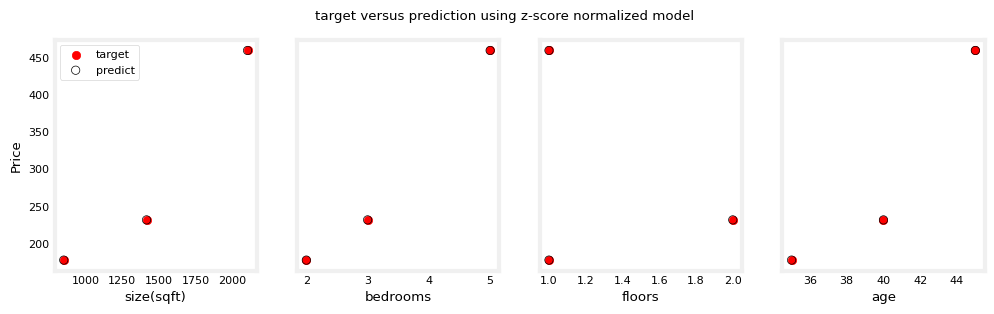

In [88]:
# plot predictions and targets vs original features
X_features = ['size(sqft)','bedrooms','floors','age']
fig,ax=plt.subplots(1,4,figsize=(12,3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(x_train[:,i],y_train,color='red', label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(x_train[:,i],y_pred, edgecolor='black',  facecolors='none', label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

Now with feature engineering we have obtained way better results than without it.


# Feature Engineering and Polynomial Regression Overview

Out of the box, linear regression provides a means of building models of the form:
$$f_{\mathbf{w},b} = w_0x_0 + w_1x_1+ ... + w_{n-1}x_{n-1} + b \tag{1}$$
What if your features/data are non-linear or are combinations of features? For example,  Housing prices do not tend to be linear with living area but penalize very small or very large houses resulting in the curves. How can we use the machinery of linear regression to fit this curve?
The 'machinery' we have is the ability to modify the parameters $\mathbf{w}$, $\mathbf{b}$ in (1) to 'fit' the equation to the training data. However, no amount of adjusting of $\mathbf{w}$,$\mathbf{b}$ in (1) will achieve a fit to a non-linear curve.


## Polynomial Features

Above we were considering a scenario where the data was non-linear. Let's try using what we know so far to fit a non-linear curve. We'll start with a simple quadratic: $y = 1+x^2$



Iteration         0, Cost: 1.65756e+03
Iteration       100, Cost: 6.94549e+02
Iteration       200, Cost: 5.88475e+02
Iteration       300, Cost: 5.26414e+02
Iteration       400, Cost: 4.90103e+02
Iteration       500, Cost: 4.68858e+02
Iteration       600, Cost: 4.56428e+02
Iteration       700, Cost: 4.49155e+02
Iteration       800, Cost: 4.44900e+02
Iteration       900, Cost: 4.42411e+02
w,b found by gradient descent: w: [18.7], b: -52.0834


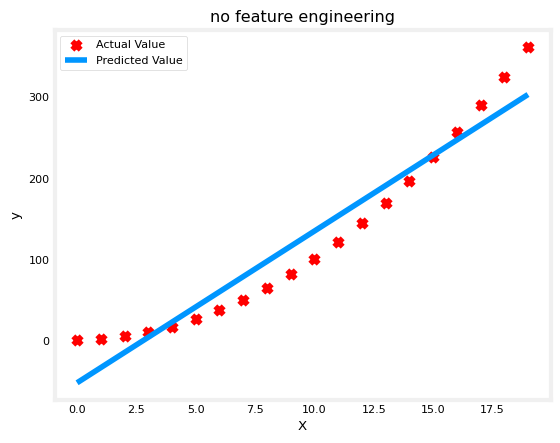

In [34]:
# create target data
x = np.arange(0, 20, 1)
y = 1 + x**2
X = x.reshape(-1, 1)

model_w,model_b = run_gradient_descent_feng(X,y,iterations=1000, alpha = 1e-2)

plt.scatter(x, y, marker='x', c='r', label="Actual Value"); plt.title("no feature engineering")
plt.plot(x,X@model_w + model_b, label="Predicted Value");  plt.xlabel("X"); plt.ylabel("y"); plt.legend(); plt.show()

Well, as expected, not a great fit. What is needed is something like $y= w_0x_0^2 + b$, or a **polynomial feature**.
To accomplish this, you can modify the *input data* to *engineer* the needed features. If you swap the original data with a version that squares the $x$ value, then you can achieve $y= w_0x_0^2 + b$. Let's try it. Swap `X` for `X**2` below:

In [35]:
# create target data
x = np.arange(0, 20, 1)
y = 1 + x**2

# Engineer features
X = x**2      #<-- added engineered feature

Iteration         0, Cost: 7.32922e+03
Iteration      1000, Cost: 2.24844e-01
Iteration      2000, Cost: 2.22795e-01
Iteration      3000, Cost: 2.20764e-01
Iteration      4000, Cost: 2.18752e-01
Iteration      5000, Cost: 2.16758e-01
Iteration      6000, Cost: 2.14782e-01
Iteration      7000, Cost: 2.12824e-01
Iteration      8000, Cost: 2.10884e-01
Iteration      9000, Cost: 2.08962e-01
w,b found by gradient descent: w: [1.], b: 0.0490


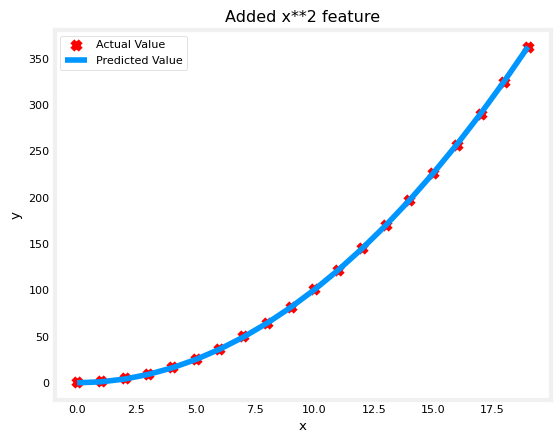

In [36]:
X = X.reshape(-1, 1)  #X should be a 2-D Matrix
model_w,model_b = run_gradient_descent_feng(X, y, iterations=10000, alpha = 1e-5)

plt.scatter(x, y, marker='x', c='r', label="Actual Value"); plt.title("Added x**2 feature")
plt.plot(x, np.dot(X,model_w) + model_b, label="Predicted Value"); plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

Great! near perfect fit. Notice the values of $\mathbf{w}$ and b printed right above the graph: `w,b found by gradient descent: w: [1.], b: 0.0490`. Gradient descent modified our initial values of $\mathbf{w},b $ to be (1.0,0.049) or a model of $y=1*x_0^2+0.049$, very close to our target of $y=1*x_0^2+1$. If you ran it longer, it could be a better match.

### Selecting Features
<a name='GDF'></a>
Above, we knew that an $x^2$ term was required. It may not always be obvious which features are required. One could add a variety of potential features to try and find the most useful. For example, what if we had instead tried : $y=w_0x_0 + w_1x_1^2 + w_2x_2^3+b$ ?

In [39]:
# create target data
x = np.arange(0, 20, 1)
y = x**2

# engineer features .
X = np.c_[x, x**2, x**3]

Iteration         0, Cost: 1.14029e+03
Iteration      1000, Cost: 3.28539e+02
Iteration      2000, Cost: 2.80443e+02
Iteration      3000, Cost: 2.39389e+02
Iteration      4000, Cost: 2.04344e+02
Iteration      5000, Cost: 1.74430e+02
Iteration      6000, Cost: 1.48896e+02
Iteration      7000, Cost: 1.27100e+02
Iteration      8000, Cost: 1.08495e+02
Iteration      9000, Cost: 9.26132e+01
w,b found by gradient descent: w: [0.08 0.54 0.03], b: 0.0106


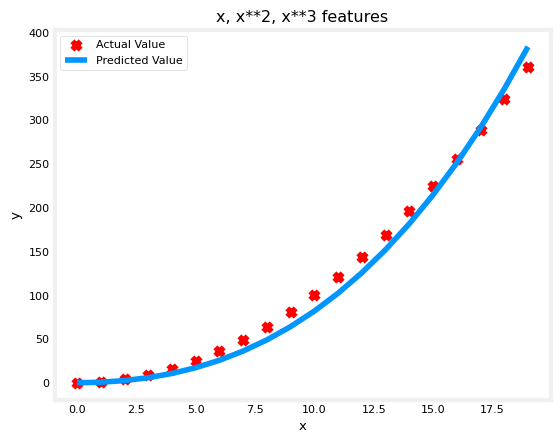

In [38]:
model_w,model_b = run_gradient_descent_feng(X, y, iterations=10000, alpha=1e-7)

plt.scatter(x, y, marker='x', c='r', label="Actual Value"); plt.title("x, x**2, x**3 features")
plt.plot(x, X@model_w + model_b, label="Predicted Value"); plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

Note the value of $\mathbf{w}$, `[0.08 0.54 0.03]` and b is `0.0106`.This implies the model after fitting/training is:
$$ 0.08x + 0.54x^2 + 0.03x^3 + 0.0106 $$
Gradient descent has emphasized the data that is the best fit to the $x^2$ data by increasing the $w_1$ term relative to the others.  If you were to run for a very long time, it would continue to reduce the impact of the other terms.
>Gradient descent is picking the 'correct' features for us by emphasizing its associated parameter

Let's review this idea:
- less weight value implies less important/correct feature, and in extreme, when the weight becomes zero or very close to zero, the associated feature is not useful in fitting the model to the data.
- above, after fitting, the weight associated with the $x^2$ feature is much larger than the weights for $x$ or $x^3$ as it is the most useful in fitting the data.

### An Alternate View
Above, polynomial features were chosen based on how well they matched the target data. Another way to think about this is to note that we are still using linear regression once we have created new features. Given that, the best features will be linear relative to the target. This is best understood with an example.

In [40]:
# create target data
x = np.arange(0, 20, 1)
y = x**2

# engineer features .
X = np.c_[x, x**2, x**3]   #<-- added engineered feature
X_features = ['x','x^2','x^3']

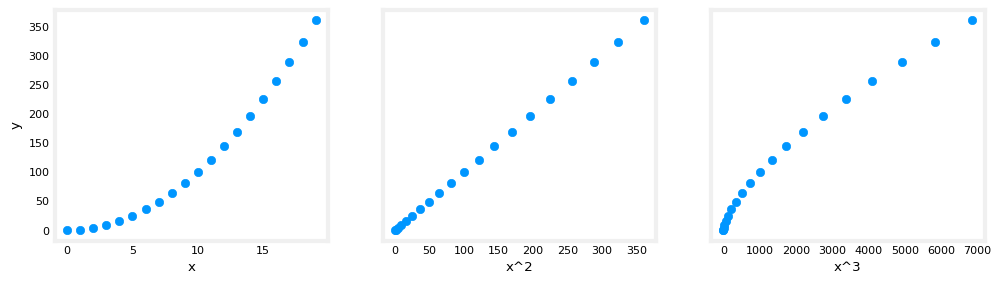

In [41]:
fig,ax=plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X[:,i],y)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("y")
plt.show()

Above, it is clear that the $x^2$ feature mapped against the target value $y$ is linear. Linear regression can then easily generate a model using that feature.

### Scaling features
 If the data set has features with significantly different scales, one should apply feature scaling to speed gradient descent. In the example above, there is $x$, $x^2$ and $x^3$ which will naturally have very different scales. Let's apply Z-score normalization to our example.

In [42]:
# create target data
x = np.arange(0,20,1)
X = np.c_[x, x**2, x**3]
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X,axis=0)}")

# add mean_normalization
X = zscore_normalize_features(X)
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X,axis=0)}")

Peak to Peak range by column in Raw        X:[  19  361 6859]
Peak to Peak range by column in Normalized X:[3.3  3.18 3.28]


Now we can try again with a more aggressive value of alpha:

Iteration         0, Cost: 9.42147e+03
Iteration     10000, Cost: 3.90938e-01
Iteration     20000, Cost: 2.78389e-02
Iteration     30000, Cost: 1.98242e-03
Iteration     40000, Cost: 1.41169e-04
Iteration     50000, Cost: 1.00527e-05
Iteration     60000, Cost: 7.15855e-07
Iteration     70000, Cost: 5.09763e-08
Iteration     80000, Cost: 3.63004e-09
Iteration     90000, Cost: 2.58497e-10
w,b found by gradient descent: w: [5.27e-05 1.13e+02 8.43e-05], b: 123.5000


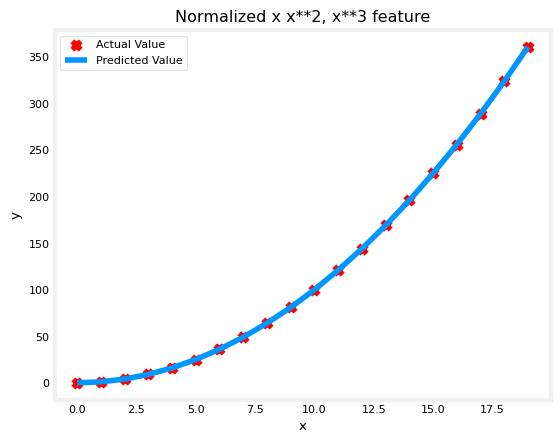

In [43]:
x = np.arange(0,20,1)
y = x**2

X = np.c_[x, x**2, x**3]
X = zscore_normalize_features(X)

model_w, model_b = run_gradient_descent_feng(X, y, iterations=100000, alpha=1e-1)

plt.scatter(x, y, marker='x', c='r', label="Actual Value"); plt.title("Normalized x x**2, x**3 feature")
plt.plot(x,X@model_w + model_b, label="Predicted Value"); plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

Feature scaling allows this to converge much faster.   
Note again the values of $\mathbf{w}$. The $w_1$ term, which is the $x^2$ term is the most emphasized. Gradient descent has all but eliminated the $x^3$ term.

##Complex Functions
With feature engineering, even quite complex functions can be modeled:

Iteration         0, Cost: 2.20188e-01
Iteration    100000, Cost: 1.70074e-02
Iteration    200000, Cost: 1.27603e-02
Iteration    300000, Cost: 9.73032e-03
Iteration    400000, Cost: 7.56440e-03
Iteration    500000, Cost: 6.01412e-03
Iteration    600000, Cost: 4.90251e-03
Iteration    700000, Cost: 4.10351e-03
Iteration    800000, Cost: 3.52730e-03
Iteration    900000, Cost: 3.10989e-03
w,b found by gradient descent: w: [ -1.34 -10.    24.78   5.96 -12.49 -16.26  -9.51   0.59   8.7   11.94
   9.27   0.79 -12.82], b: -0.0073


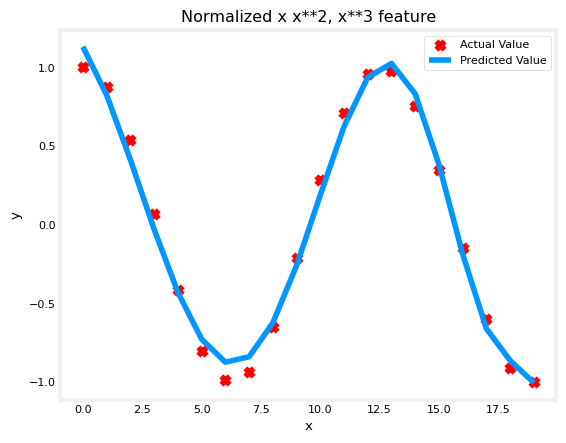

In [44]:
x = np.arange(0,20,1)
y = np.cos(x/2)

X = np.c_[x, x**2, x**3,x**4, x**5, x**6, x**7, x**8, x**9, x**10, x**11, x**12, x**13]
X = zscore_normalize_features(X)

model_w,model_b = run_gradient_descent_feng(X, y, iterations=1000000, alpha = 1e-1)

plt.scatter(x, y, marker='x', c='r', label="Actual Value"); plt.title("Normalized x x**2, x**3 feature")
plt.plot(x,X@model_w + model_b, label="Predicted Value"); plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()
